In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# have data file already?
have_data_file = False  # if True, load data from file
                        # if False, run simulation (and save data)

if have_data_file:
    # load data from this path (including file name)
    data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'
else:
    # save simulated data?
    save_data = False
    # file name for new simulated data to be saved
    filename_data = 'data-varying-cue-intensity_yyyy-mm-dd.npz'

# save simulated data and/or figure panel(s) to this path (excluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 2h?
save_fig2h = False
# save figure panel 2i?
save_fig2i = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file names
filename_fig2h = 'fig2h-varying-cue-intensity_yyyy-mm-dd'
filename_fig2i = 'fig2i-varying-cue-intensity_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
"""specify simulation parameters"""

# number of simulation runs
n_sims = 100

# array of ER amplitude scales, similar to cue intensities
ER_amplitude_scale_array = np.arange(0, 2.05, 0.05)
n_params = len(ER_amplitude_scale_array)

# specify gamma decay parameter
gamma_decay = 17

# simulation time parameters
T_train = 120               # length of training [s]
t_test_begins = T_train     # time when testing begins [s]
T_test = 30                 # length of testing [s]
T = T_train + T_test        # total length of simulation [s]

# ER baseline noise
ER_baseline_factor = 0.45

# specify window size for computing offset variability
windowsize_offset_variability = 3200  # [steps], equivalent to 8 [s] in simulation

# specify standard deviation of Gaussian kernel for smoothing ER->EPG weight matrix
sigma_smooth = 2

# initialize weight norm
W_norm_init = 1.5


"""create ring attractor object"""

ra = RingAttractorNetwork(network_params)
ra.gamma_Hebb = 1
ra.gamma_postboost = 1
ra.gamma_decay = gamma_decay
ra.eta = 5e-5

# number of time steps
n_timesteps = int(T / ra.dt)
n_timesteps_train = int(T_train / ra.dt)
n_timesteps_test = int(T_test / ra.dt)

# ER baseline noise
ER_baseline = ER_baseline_factor * np.sum(ra.r_init)

In [7]:
"""steady-state HD encoding accuracy, bump parameters, and max-min weight vs. cue intensity"""

if have_data_file == False:

    # generate list of random seeds
    rng_seeds = [random.randrange(2**32-1) for i_sim in range(n_sims)]

    # initialize data arrays
    offset_variability_array = np.full((n_sims, n_params), np.nan)
    bump_width_array = np.full((n_sims, n_params), np.nan)
    bump_amplitude_array = np.full((n_sims, n_params), np.nan)
    W_notch_depth_array = np.full((n_sims, n_params), np.nan)

    ER_amplitude_array = np.full((n_params), np.nan)

    for i_sim in tqdm(range(n_sims)):
        # generate ground truth AV and HD
        v_AV, z_HD = generate_ground_truth(ra.dt, T)

        # generate AV input noise
        noise_AV = generate_AV_input_noise(ra.dt, T)

        # determine random initialization for weight matrix
        W_init = np.random.uniform(0, 1, (ra.N, ra.N))
        W_init = W_norm_init * W_init / np.linalg.norm(W_init)

        for i_param, ER_amplitude_scale in enumerate(tqdm(ER_amplitude_scale_array)):
            # seed random number generator
            rng_seed = rng_seeds[i_sim]
            np.random.seed(rng_seed)

            # generate ER input and noise
            g, _, ER_amplitude = generate_ER_input(ra, T, v_AV, z_HD, h_scale = ER_amplitude_scale)
            noise_g = generate_ER_input_noise(g)                # shape (n_timesteps, ra.N)
            noise_g = noise_g.T / np.sum(noise_g, axis = 1)     # shape (ra.N, n_timesteps)
            noise_g = ER_baseline * noise_g
            noise_g = noise_g.T                                 # shape (n_timesteps, ra.N)

            ER_amplitude_array[i_param] = ER_amplitude

            # reset network activity
            ra.reset_network()

            # initialize weight matrix
            ra.W = np.copy(W_init)

            # simulate
            ra.simulate(T, v = v_AV + noise_AV, g = g + noise_g, learn = True, trace = True)

            # extract bump position
            bump_pos = ra.determine_bumpPosition(ydata = ra.r_trace)

            # get ER->EPG weight matrices across time
            W_trace = ra.W_trace.copy()

            # initialize temporary data arrays
            offset_variability_vs_t = np.full((n_timesteps_test), np.nan)
            bump_width_vs_t = np.full((n_timesteps_test), np.nan)
            bump_amplitude_vs_t = np.full((n_timesteps_test), np.nan)
            W_notch_depth_vs_t = np.full((n_timesteps_test), np.nan)

            for t_step in range(n_timesteps_test):
                idx = t_step + n_timesteps_train

                # extract bump parameters
                bump_amplitude_vs_t[t_step], bump_width_vs_t[t_step] = ra.determine_features_basic(ind = idx)

                # compute offset variability
                window_bump_pos = sliding_window(bump_pos, idx, windowsize_offset_variability)
                window_z = sliding_window(z_HD, idx, windowsize_offset_variability)
                offset_variability_vs_t[t_step] = offset_variation(window_bump_pos, window_z)

                # smooth ER->EPG weight matrix with Gaussian filter
                W_smoothed = gaussian_filter(W_trace[idx], sigma_smooth, mode = 'wrap')

                # compute weight matrix notch depth, i.e. max-min
                W_notch_depth_vs_t[t_step] = np.max(W_smoothed) - np.min(W_smoothed)

            # compute steady-state values
            offset_variability_array[i_sim, i_param] = np.mean(offset_variability_vs_t)
            bump_width_array[i_sim, i_param] = np.mean(bump_width_vs_t)
            bump_amplitude_array[i_sim, i_param] = np.mean(bump_amplitude_vs_t)
            W_notch_depth_array[i_sim, i_param] = np.mean(W_notch_depth_vs_t)

    # compute HD encoding accuracy from offset variability
    HD_encoding_accuracy_array = 1 - offset_variability_array

In [8]:
"""ER activity, EPG activity, and weight matrix for zero, low, and high cue intensities"""

rng_seed = random.randrange(2**32-1)

# array of ER amplitude scales corresponding to zero, low, and high cue intensities
ER_amplitude_scale_array = np.array([0, 1, 2])
n_intensities = len(ER_amplitude_scale_array)   # number of cue intensities

# initialize data arrays
ER_activity_array = np.full((n_intensities, ra.N), np.nan)
EPG_activity_array = np.full((n_intensities, ra.N), np.nan)
W_array = np.full((n_intensities, ra.N, ra.N), np.nan)
ER_amplitude_array = np.full((n_intensities), np.nan)

input2HD_array = np.full((n_intensities, ra.N), np.nan)

# generate ground truth AV and HD
v_AV, z_HD = generate_ground_truth(ra.dt, T)

# generate AV input noise
noise_AV = generate_AV_input_noise(ra.dt, T)

# determine random initialization for weight matrix
W_init = np.random.uniform(0, 1, (ra.N, ra.N))
W_init = W_norm_init * W_init / np.linalg.norm(W_init)

for i_intensity, ER_amplitude_scale in enumerate(tqdm(ER_amplitude_scale_array)):
    np.random.seed(rng_seed)

    # generate ER input
    g, _, ER_amplitude = generate_ER_input(ra, T, v_AV, z_HD, h_scale = ER_amplitude_scale)
    ER_amplitude_array[i_intensity] = ER_amplitude

    # generate ER input noise
    noise_g = generate_ER_input_noise(g)                # shape (n_timesteps, ra.N)
    noise_g = noise_g.T / np.sum(noise_g, axis = 1)     # shape (ra.N, n_timesteps)
    noise_g = ER_baseline * noise_g
    noise_g = noise_g.T                                 # shape (n_timesteps, ra.N)

    # reset network activity
    ra.reset_network()

    # initialize weight matrix
    ra.W = np.copy(W_init)

    # simulate
    ra.simulate(T, v = v_AV + noise_AV, g = g + noise_g, learn = True, trace = False)

    # record activities and weights at last time step
    ER_activity_array[i_intensity] = g[-1] + noise_g[-1]
    EPG_activity_array[i_intensity] = ra.r.copy()
    W_array[i_intensity] = ra.W.copy()
    input2HD_array[i_intensity] = ra.W @ (g[-1] + noise_g[-1])

100%|██████████| 3/3 [00:08<00:00,  2.81s/it]


In [9]:
"""save data arrays"""

if have_data_file == True:
    pass
else:
    if save_data == True:
        np.savez(os.path.join(save2path, filename_data),
            offset_variability_array = offset_variability_array,
            HD_encoding_accuracy_array = HD_encoding_accuracy_array,
            bump_width_array = bump_width_array,
            bump_amplitude_array = bump_amplitude_array,
            W_notch_depth_array = W_notch_depth_array,
            ER_amplitude_array = ER_amplitude_array,
            rng_seeds = rng_seeds
        )

In [10]:
"""load data arrays"""

if have_data_file == True:
    with np.load(data_path) as data_arrays:
        offset_variability_array = data_arrays['offset_variability_array']
        HD_encoding_accuracy_array = data_arrays['HD_encoding_accuracy_array']
        bump_width_array = data_arrays['bump_width_array']
        bump_amplitude_array = data_arrays['bump_amplitude_array']
        W_notch_depth_array = data_arrays['W_notch_depth_array']
        ER_amplitude_array = data_arrays['ER_amplitude_array']

In [11]:
"""averaging"""

offset_variability_mean = np.mean(offset_variability_array, axis=0)
offset_variability_sem = np.std(offset_variability_array, axis=0) / np.sqrt(n_sims)

HD_encoding_accuracy_mean = np.mean(HD_encoding_accuracy_array, axis=0)
HD_encoding_accuracy_sem = np.std(HD_encoding_accuracy_array, axis=0) / np.sqrt(n_sims)

bump_amplitude_mean = np.mean(bump_amplitude_array, axis=0)
bump_amplitude_sem = np.std(bump_amplitude_array, axis=0) / np.sqrt(n_sims)

bump_width_mean = np.mean(bump_width_array, axis=0)
bump_width_sem = np.std(bump_width_array, axis=0) / np.sqrt(n_sims)

W_notch_depth_mean = np.mean(W_notch_depth_array, axis=0)
W_notch_depth_sem = np.std(W_notch_depth_array, axis=0) / np.sqrt(n_sims)

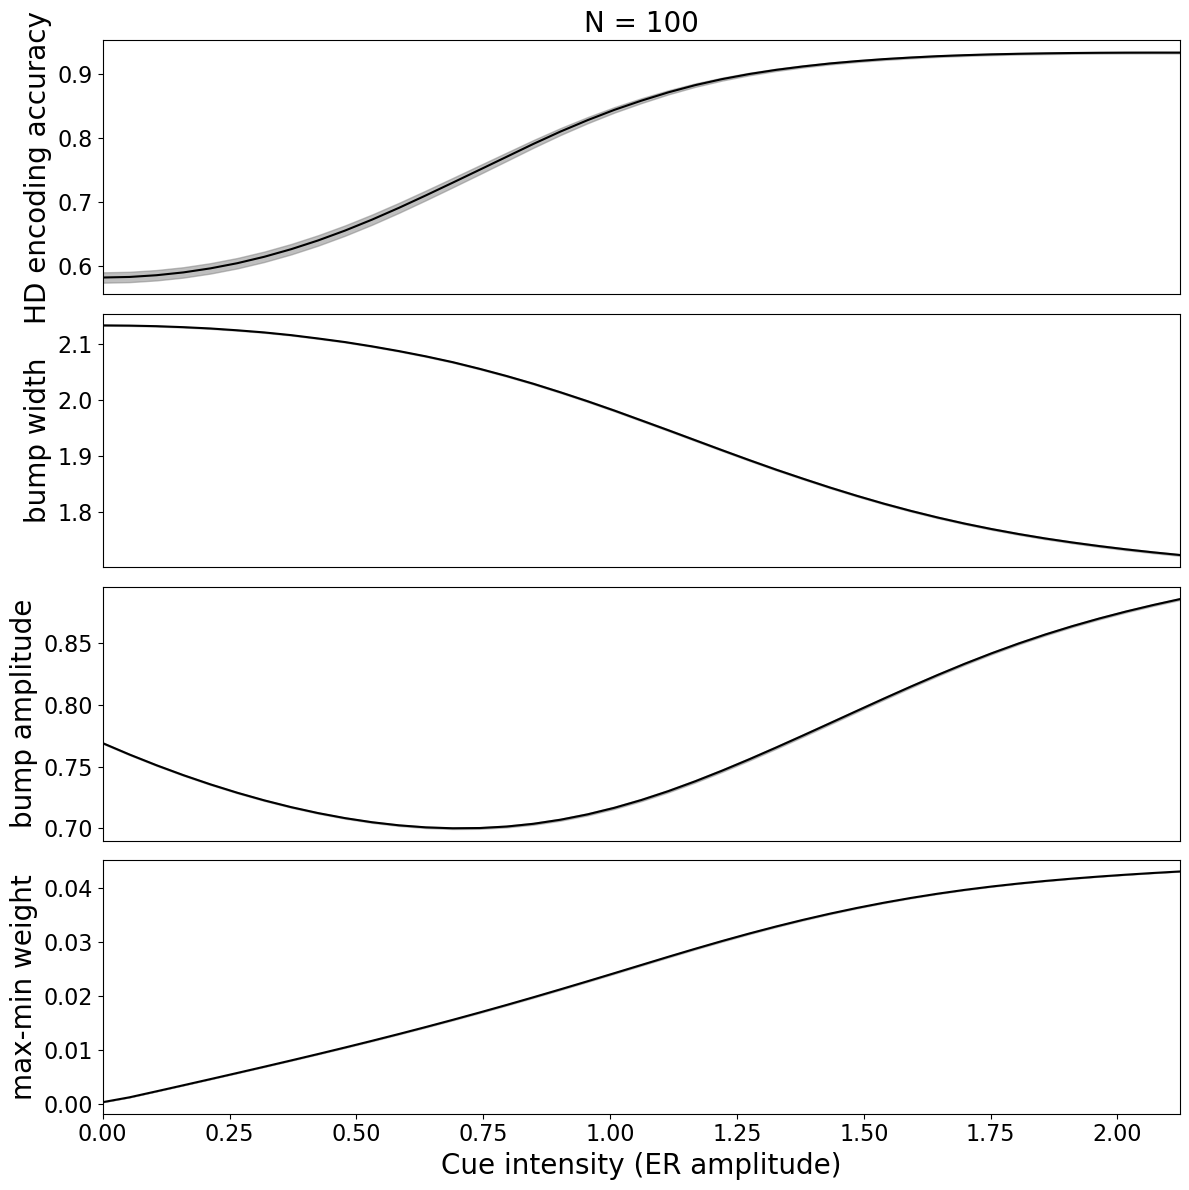

In [12]:
"""visualization - steady-state HD encoding accuracy, bump parameters, and max-min weight vs. cue intensity"""

plot_fig2h = True

if plot_fig2h:
    """specify x-axis tick marks and labels"""

    # array of tick locations along x-axis
    xtick_locations = np.arange(0, 2.25, 0.25)

    """generate figure"""

    fig_2h, ax_2h = plt.subplots(4, 1, figsize = (12, 12))

    ax_2h[0].set_title(f'N = {n_sims}')

#    ax_2i[0].plot(ER_amplitude_array, HD_encoding_accuracy_array.T, color='green', alpha=0.5)

    # plot HD encoding accuracy vs. cue intensity
    ax_2h[0].plot(ER_amplitude_array, HD_encoding_accuracy_mean, color='k')
    ax_2h[0].fill_between(
        ER_amplitude_array, HD_encoding_accuracy_mean - HD_encoding_accuracy_sem,
        HD_encoding_accuracy_mean + HD_encoding_accuracy_sem, color='gray', alpha=0.5
    )
    ax_2h[0].set_ylabel('HD encoding accuracy')
    ax_2h[0].set_xlim(0, max(ER_amplitude_array))
    ax_2h[0].set_xticks([])

    # plot bump width vs. cue intensity
    ax_2h[1].plot(ER_amplitude_array, bump_width_mean, color='k')
    ax_2h[1].fill_between(
        ER_amplitude_array, bump_width_mean - bump_width_sem,
        bump_width_mean + bump_width_sem, color='gray', alpha=0.5
    )
    ax_2h[1].set_ylabel('bump width')
    ax_2h[1].set_xlim(0, max(ER_amplitude_array))
    ax_2h[1].set_xticks([])

    # plot bump amplitude vs. cue intensity
    ax_2h[2].plot(ER_amplitude_array, bump_amplitude_mean, color='k')
    ax_2h[2].fill_between(
        ER_amplitude_array, bump_amplitude_mean - bump_amplitude_sem,
        bump_amplitude_mean + bump_amplitude_sem, color='gray', alpha=0.5
    )
    ax_2h[2].set_ylabel('bump amplitude')
    ax_2h[2].set_xlim(0, max(ER_amplitude_array))
    ax_2h[2].set_xticks([])

    # plot notch depth (max - min) vs. time
    ax_2h[3].plot(ER_amplitude_array, W_notch_depth_mean, color='k')
    ax_2h[3].fill_between(
        ER_amplitude_array, W_notch_depth_mean - W_notch_depth_sem,
        W_notch_depth_mean + W_notch_depth_sem, color='gray', alpha=0.5
    )
    ax_2h[3].set_xlabel('Cue intensity (ER amplitude)')
    ax_2h[3].set_ylabel('max-min weight')
    ax_2h[3].set_xlim(0, max(ER_amplitude_array))
    ax_2h[3].set_xticks(xtick_locations)

    plt.tight_layout()

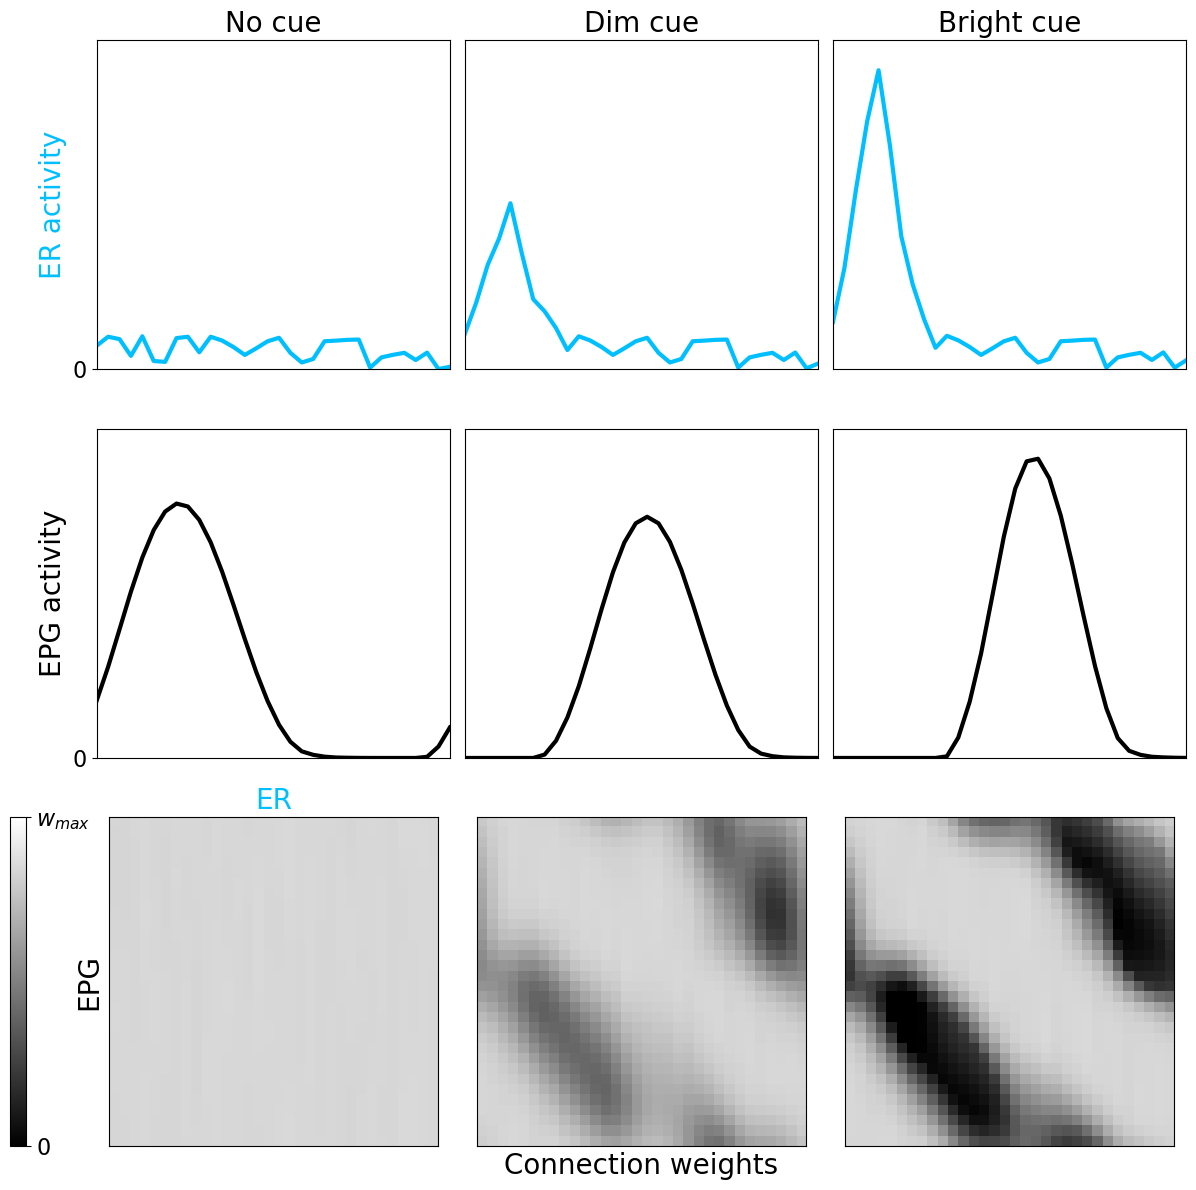

In [13]:
"""visualization - ER activity, EPG activity, and weight matrix for zero, low, and high cue intensities"""

plot_fig2i = True

# compute w_max
w_max = ra.gamma_postboost / ra.gamma_decay

if plot_fig2i:
    fig_2i, ax_2i = plt.subplots(3, 3, figsize=(12, 12))
    im = []

    ax_2i[0, 0].set_title('No cue')
    ax_2i[0, 1].set_title('Dim cue')
    ax_2i[0, 2].set_title('Bright cue')

    ax_2i[0, 0].set_ylabel('ER activity', color='deepskyblue')
    ax_2i[1, 0].set_ylabel('EPG activity')

    ax_2i[2, 0].set_title('ER', color='deepskyblue')
    ax_2i[2, 0].set_ylabel('EPG')
    ax_2i[2, 1].set_xlabel('Connection weights')

    ax_2i[0, 0].set_yticks([0])
    ax_2i[0, 1].set_yticks([])
    ax_2i[0, 2].set_yticks([])
    ax_2i[1, 0].set_yticks([0])
    ax_2i[1, 1].set_yticks([])
    ax_2i[1, 2].set_yticks([])

    for i in range(n_intensities):
        ax_2i[0, i].plot(np.arange(ra.N), ER_activity_array[i], linewidth=3, color='deepskyblue')
        ax_2i[0, i].set_xlim(0, ra.N - 1)
        ax_2i[0, i].set_ylim(0, 1.1 * np.max(ER_activity_array[-1]))
        ax_2i[0, i].set_xticks([])

        ax_2i[1, i].plot(np.arange(ra.N), EPG_activity_array[i], linewidth=3, color='k')
        ax_2i[1, i].set_xlim(0, ra.N - 1)
        ax_2i[1, i].set_ylim(0, 1.1 * np.max(EPG_activity_array[-1]))
        ax_2i[1, i].set_xticks([])

        im.append(ax_2i[2, i].imshow(W_array[i], vmin=0, vmax=w_max, aspect='equal', cmap='gray'))
        ax_2i[2, i].set_xticks([])
        ax_2i[2, i].set_yticks([])

    grayscalebar_ax = ax_2i[2, 0].inset_axes([-0.3, 0, 0.05, 1])
    grayscalebar = fig_2i.colorbar(im[0], ax=ax_2i[2, 0], cax=grayscalebar_ax)
    grayscalebar.set_ticks([0, w_max])
    grayscalebar.set_ticklabels([0, '$w_{max}$'])

    plt.tight_layout()

In [14]:
"""save figure panels"""

if save_fig2h:
    fig_2h.savefig(os.path.join(save2path, filename_fig2h + '.' + fig_format), format=fig_format)

if save_fig2i:
    fig_2i.savefig(os.path.join(save2path, filename_fig2i + '.' + fig_format), format=fig_format)